In [2]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
from cosmic.utils import convert_kstar_evol_type
from cosmic.plotting import evolve_and_plot

import numpy as np
import matplotlib.pyplot as plt
import tqdm
from matplotlib.colors import LogNorm

In [3]:
# Helper functions and variables for unit conversions

def aui_to_porb(aui, m_tot):
    # aui: a list of values, initial separation in AU
    # m_tot: a list of values, total mass in M_sun
    # result: a list of values, orbital period in given condition in days
    res = []
    for i in range(len(aui)):
        res.append((1/m_tot[i]**0.5) * (aui[i]**1.5) * 365)
    return res

# Used to convert separation in R_sun into AU
unit_factor = 1 / 215.032

# Helper function: given an array of data and an array of target,
# return an array of index that is nearest to the target value.
import math 
def findNearestList(data, targetList):
    res = []
    for num in targetList:
        res.append(findNearest(data, num))
    return res

def findNearest(data, target):
    n = len(data)
    res = -1
    minDiff = 10**5
    for i in range(n):
        if data[i] == 10**(-5):
            continue
        if abs(target - data[i]) <= minDiff:
            res = i
            minDiff = abs(target - data[i])
    return res

In [4]:
NUM_DICT = 2000
NUM_SEP = 400

MASS_1 = 1.5
MASS_2 = 0.85
MASS_TOT = 2.35

ECC = 0

SEP_START = 0.5
SEP_END = 6

LAMBDA_START = -100
LAMBDA_END = 0

SOLAR_MET = 0.02

TPHYS_LIM = 6000

In [5]:
# Default BSEDict
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 
           'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 
           'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 
           'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 
           'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag' : 0, 'wd_mass_lim': 1}

In [6]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [7]:
csv_file_path = '1.5+0.8 alpha=1 result.csv'
data1 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '1.5+0.8 alpha=0.9 result.csv'
data2 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '1.5+0.8 alpha=0.6 result.csv'
data3 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '1.5+0.8 alpha=0.3 result.csv'
data4 = np.genfromtxt(csv_file_path, delimiter=',')

In [8]:
# Create a list of BSEDict for different lambdaf values
# lambdaf ranges from 0 to -10 with NUM_DICT values in between

lambdaList = np.linspace(LAMBDA_START, LAMBDA_END, NUM_DICT, endpoint=False)
print(lambdaList)

BSEDictList = [BSEDict.copy() for i in range(NUM_DICT)]
for i in range(NUM_DICT):
    BSEDictList[i]['lambdaf'] = lambdaList[i]

[-1.000e+02 -9.995e+01 -9.990e+01 ... -1.500e-01 -1.000e-01 -5.000e-02]


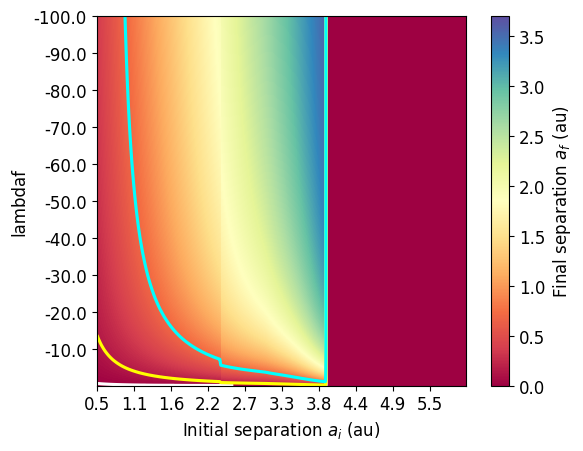

In [18]:
plt.imshow(data1, cmap='Spectral', aspect = 0.2, vmin=0, vmax=3.7)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data1.shape[1], 40)
y_tick_locations = np.arange(0, data1.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label

plt.contour(data1, levels=[0.01, 0.15, 0.7], colors=['white', 'yellow', 'cyan'], linewidths = 2.25)
plt.savefig('1.5+0.8 Heatmap, alpha = 1.png', dpi=300)
plt.show()

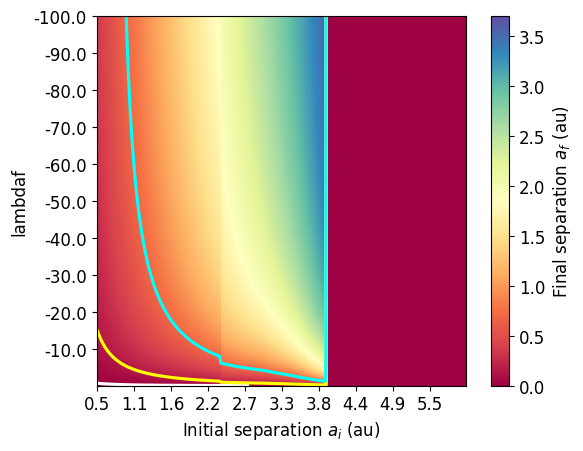

In [19]:
plt.imshow(data2, cmap='Spectral', aspect = 0.2, vmin=0, vmax=3.7)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data2.shape[1], 40)
y_tick_locations = np.arange(0, data2.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label
plt.contour(data2, levels=[0.01, 0.15, 0.7], colors=['white', 'yellow', 'cyan'], linewidths = 2.25)
plt.savefig('1.5+0.8 Heatmap, alpha = 0.9.png', dpi=300)
plt.show()

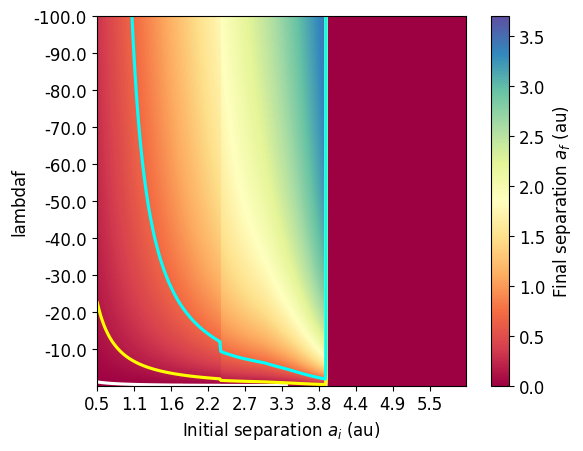

In [20]:
plt.imshow(data3, cmap='Spectral', aspect = 0.2, vmin=0, vmax=3.7)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data3.shape[1], 40)
y_tick_locations = np.arange(0, data3.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label
plt.contour(data3, levels=[0.01, 0.15, 0.7], colors=['white', 'yellow', 'cyan'], linewidths = 2.25)
plt.savefig('1.5+0.8 Heatmap, alpha = 0.6.png', dpi=300)
plt.show()

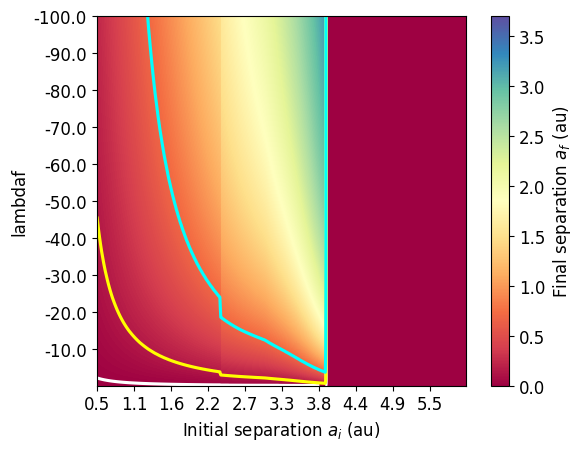

In [21]:
plt.imshow(data4, cmap='Spectral', aspect = 0.2, vmin=0, vmax=3.7)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data4.shape[1], 40)
y_tick_locations = np.arange(0, data4.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label
plt.contour(data4, levels=[0.01, 0.15, 0.7], colors=['white', 'yellow', 'cyan'], linewidths = 2.25)
plt.savefig('1.5+0.8 Heatmap, alpha = 0.3.png', dpi=300)
plt.show()